In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as data

In [9]:
df = pd.read_csv("/home/dlwhdtmd/boiler/미국시카고보일러_계절.csv")
df["날짜"] = pd.to_datetime(df["날짜"])
df.set_index("날짜", inplace=True)

In [13]:
# 계절 str -> 겨울 :4, 봄 :1, 여름 :2, 가을 :3 으로 대체
## 

df["season_dummies"] = df["계절"].map({"겨울":4, "봄":1, "여름":2, "가을":3})
df.drop("계절", axis=1, inplace=True)

In [ ]:
df.info()
# 보일러 유량1 :  메인 보일러
# 보일러 유량2  : 서브 보일러 

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 525540 entries, 2018-01-01 01:00:00 to 2018-12-31 23:59:00
Data columns (total 23 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   보일러 유량 1        525540 non-null  float64
 1   보일러 유량 2        525540 non-null  float64
 2   보일러 가스 소비량 1    525540 non-null  float64
 3   보일러 가스 소비량 2    525540 non-null  float64
 4   보일러 환수 온도 1     525540 non-null  float64
 5   보일러 환수 온도 2     525540 non-null  float64
 6   보일러 상태 1        525540 non-null  float64
 7   보일러 상태 2        525540 non-null  float64
 8   보일러 출수 온도 1     525540 non-null  float64
 9   보일러 출수 온도 2     525540 non-null  float64
 10  온수 루프 차압        525540 non-null  float64
 11  온수 루프 온도 설정값    525540 non-null  float64
 12  온수 루프 환수 온도     525540 non-null  float64
 13  온수 루프 공급수 온도    525540 non-null  float64
 14  외기 건구온도         525540 non-null  float64
 15  펌프 전력 소비량 1     525540 non-null  float64
 16  펌프 전력 소비량 2     525540

In [40]:
print(df["보일러 상태 1"]) # 해당 코드 확인결과 무조건 on으로 작동

날짜
2018-01-01 01:00:00    1.0
2018-01-01 01:01:00    1.0
2018-01-01 01:02:00    1.0
2018-01-01 01:03:00    1.0
2018-01-01 01:04:00    1.0
                      ... 
2018-12-31 23:55:00    1.0
2018-12-31 23:56:00    1.0
2018-12-31 23:57:00    1.0
2018-12-31 23:58:00    1.0
2018-12-31 23:59:00    1.0
Name: 보일러 상태 1, Length: 525540, dtype: float64


In [42]:
print(df_filter.columns)

Index(['보일러 유량 1', '보일러 유량 2', '보일러 가스 소비량 1', '보일러 가스 소비량 2', '보일러 환수 온도 1',
       '보일러 환수 온도 2', '보일러 상태 1', '보일러 상태 2', '보일러 출수 온도 1', '보일러 출수 온도 2',
       '온수 루프 차압', '온수 루프 온도 설정값', '온수 루프 환수 온도', '온수 루프 공급수 온도', '외기 건구온도',
       '펌프 전력 소비량 1', '펌프 전력 소비량 2', '펌프 속도비 1', '펌프 속도비 2', '펌프 상태 1',
       '펌프 상태 2', '2차 루프 열부하', 'season_dummies'],
      dtype='object')


## 데이터 분석 - A/B test
1. 보일러 2번의 trigger 여부
    - 가설 : 기온에 따른 보일러 2가 켜질것이다 -> 그럼 어느 시점에서 많이 켜지는지?

2. 이를 기반으로 한 수요량 패턴 분석
    - 보조기인 2번이 켜진 이유가 무조건 수요량에 있을것이라고 판단.

In [ ]:
# 그렇다면 보일러 상태 2가 작동됐을때 시점을 뽑아본다.
# 분석결과 보일러의 가스소비량 2번에서 0이 찍임 ->이거 좀 이상함.
## 
df_filter = df[df["보일러 상태 2"] == 1]

print("++++++++++++++++++++++++++++++++++++++++")
print(pd.unique(df_filter["season_dummies"])) # 겨울(4)번 에서만 작동한다.

                       보일러 유량 1    보일러 유량 2  보일러 가스 소비량 1  보일러 가스 소비량 2  \
날짜                                                                        
2018-01-02 06:33:00  252.331604  202.991470   1726.882330      0.000000   
2018-01-02 06:34:00  252.551743  250.578079   1726.882330      0.000000   
2018-01-02 06:35:00  253.590698  253.550491   1726.882330      0.000000   
2018-01-02 06:36:00  255.136795  255.137192   1726.882330      0.000000   
2018-01-02 06:37:00  256.356842  256.356842   1726.882330      0.000000   
...                         ...         ...           ...           ...   
2018-12-31 08:12:00  105.365227  105.365227    701.202548    694.003206   
2018-12-31 08:13:00  105.011658  105.011658    698.654630    691.657673   
2018-12-31 08:14:00  104.808220  104.808220    697.103984    690.292487   
2018-12-31 08:15:00  104.624168  104.624168    695.784448    689.150935   
2018-12-31 08:16:00  104.390358  104.390358    694.175842    687.718922   

                     보일러

In [45]:
df_filter["ymd"] = df_filter.index.strftime("%Y-%m-%d")

/tmp/ipykernel_1304219/3142386191.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filter["ymd"] = df_filter.index.strftime("%Y-%m-%d")


In [64]:
# 주로 6시에 패턴을 많이 가지고 있는것을 확인했음.

for month, sub in grouped.groupby('월'):
    print(f"{month}월")
    for _, row in sub.iterrows():
        print(f"  {month:02d}-{row['일']:02d}: {', '.join(row['시분'])}")
    print("-" * 70)

# 저 위에서 얻은 시간값이 기온과 연관성이 있는지를 평가한다.
## 두번째는 수요 
# ① 월, 일, 시분 정보가 있는 grouped 기준
df_filter = df_filter.copy()
df_filter['월'] = df_filter.index.month
df_filter['일'] = df_filter.index.day
df_filter['시분'] = df_filter.index.strftime('%H:%M')

# ② 보일러 작동 시간대만 있는 df_filter와 전체 df_main 결합
df_main = df.copy()  # 전체 데이터프레임 (기온, 열부하 등 포함)
df_main = df_main.copy()
df_main['월'] = df_main.index.month
df_main['일'] = df_main.index.day
df_main['시분'] = df_main.index.strftime('%H:%M')

# ③ 작동 시간 여부 라벨링
df_main['보일러2작동'] = df_main.index.isin(df_filter.index).astype(int)

# ④ 평균 비교 — 작동 vs 비작동
summary = (
    df_main.groupby('보일러2작동')[['외기 건구온도', '2차 루프 열부하']]
    .mean()
    .rename(index={0: '비작동', 1: '작동'})
)
print(summary)

df_filter = df_filter.copy()
df_filter['시'] = df_filter.index.hour
df_filter['분'] = df_filter.index.minute
df_filter['시분'] = df_filter.index.strftime('%H:%M')

1월
  01-02: 06:33, 06:34, 06:35, 06:36, 06:37, 06:38, 06:39, 06:40, 06:41, 06:42, 06:43, 06:44, 06:45, 06:46, 06:47, 06:48, 06:49, 06:50, 06:51, 06:52, 06:53, 06:54, 06:55, 06:56, 06:57, 06:58, 06:59, 07:00, 07:01, 07:02, 07:03, 07:04, 07:05, 07:06, 07:07, 07:08, 07:09, 07:10, 07:11, 07:12, 07:13, 07:14, 07:15, 07:16, 07:17, 07:18, 07:19, 07:20, 07:21, 07:22, 07:23, 07:24, 07:25, 07:26, 07:27, 07:28, 07:29, 07:30, 07:31, 07:32, 07:33, 07:34, 07:35, 07:36, 07:37, 07:38, 07:39, 07:40, 07:41, 07:42, 07:43, 07:44, 07:45, 07:46, 07:47, 07:48, 07:49, 07:50, 07:51, 07:52, 07:53, 07:54, 07:55, 07:56, 07:57, 07:58, 07:59, 08:00, 08:01, 08:02, 08:03, 08:04, 08:05, 08:06, 08:07, 08:08, 08:09, 08:10, 08:11, 08:12, 08:13, 08:14, 08:15, 08:16, 08:17, 08:18, 08:19, 08:20, 08:21, 08:22, 08:23, 08:24, 08:25, 08:26, 08:27, 08:28, 08:29, 08:30, 08:31, 08:32, 08:33, 08:34, 08:35, 08:36
  01-05: 06:33, 06:34, 06:35, 06:36, 06:37, 06:38, 06:39, 06:40, 06:41, 06:42, 06:43, 06:44, 06:45, 06:46, 06:47, 06:48, 

In [ ]:
temp_load_group = (
    df_filter.groupby(['월', '일', '시분'])[['외기 건구온도', '2차 루프 열부하']]
    .mean()
    .reset_index()
)

grouped_expanded = grouped.explode('시분').reset_index(drop=True)


merged = pd.merge(grouped_expanded, temp_load_group, on=['월', '일', '시분'], how='left')

for month, sub_month in merged.groupby('월'):
    print(f"{month}월")
    for (day), sub_day in sub_month.groupby('일'):
        time_info = [
            f"{t}({temp:.1f}°C, {load:.1f}kW)"
            for t, temp, load in zip(sub_day['시분'], sub_day['외기 건구온도'], sub_day['2차 루프 열부하'])
        ]
        print(f"  {month:02d}-{day:02d}: {', '.join(time_info)}")
    print("-" * 70)

1월
  01-02: 06:33(-2.4°C, 1492.2kW), 06:34(-2.4°C, 1357.9kW), 06:35(-2.4°C, 1230.1kW), 06:36(-2.4°C, 1216.0kW), 06:37(-2.4°C, 1190.7kW), 06:38(-2.4°C, 1236.5kW), 06:39(-2.4°C, 1256.6kW), 06:40(-2.4°C, 1256.6kW), 06:41(-2.4°C, 1269.8kW), 06:42(-2.4°C, 1277.3kW), 06:43(-2.4°C, 1281.5kW), 06:44(-2.3°C, 1283.0kW), 06:45(-2.3°C, 1283.6kW), 06:46(-2.3°C, 1283.6kW), 06:47(-2.3°C, 1282.7kW), 06:48(-2.3°C, 1282.7kW), 06:49(-2.3°C, 1282.1kW), 06:50(-2.3°C, 1281.8kW), 06:51(-2.3°C, 1281.5kW), 06:52(-2.3°C, 1281.4kW), 06:53(-2.3°C, 1281.3kW), 06:54(-2.3°C, 1281.3kW), 06:55(-2.3°C, 1281.6kW), 06:56(-2.3°C, 1281.6kW), 06:57(-2.3°C, 1281.9kW), 06:58(-2.3°C, 1282.1kW), 06:59(-2.3°C, 1282.5kW), 07:00(-2.3°C, 1282.7kW), 07:01(-2.3°C, 1283.2kW), 07:02(-2.3°C, 1435.3kW), 07:03(-2.3°C, 1435.0kW), 07:04(-2.3°C, 1435.0kW), 07:05(-2.3°C, 1434.1kW), 07:06(-2.3°C, 1430.1kW), 07:07(-2.3°C, 1429.1kW), 07:08(-2.3°C, 1428.4kW), 07:09(-2.3°C, 1430.1kW), 07:10(-2.3°C, 1433.2kW), 07:11(-2.3°C, 1440.6kW), 07:12(-2.3°C,

In [89]:
df_main["ymd"] = df_main.index.strftime("%Y-%m-%d")

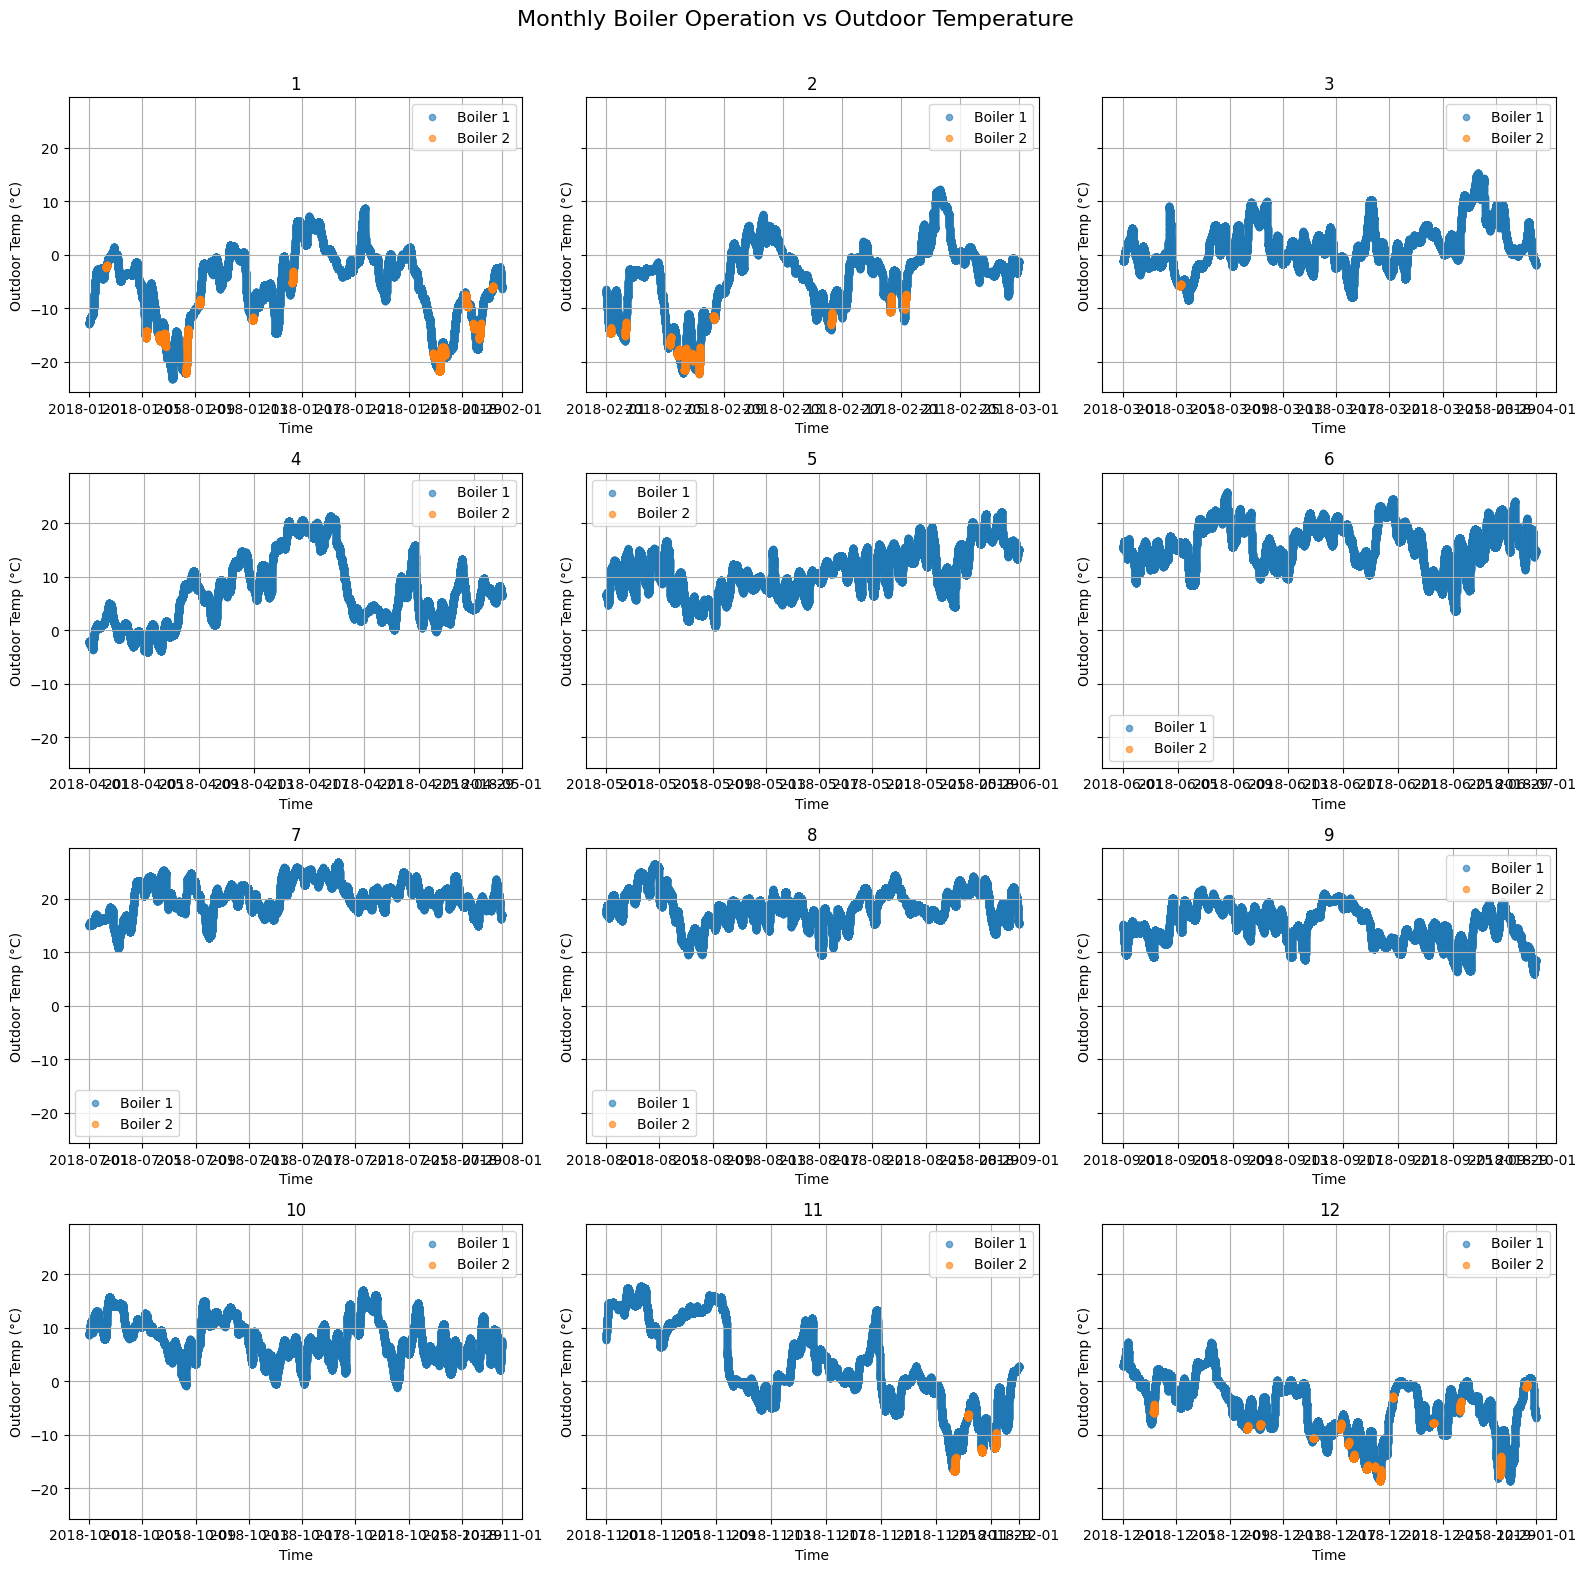

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd

df_main['datetime'] = pd.to_datetime(df_main['ymd'] + ' ' + df_main['시분'])

# 월별 유효 월만 추출 (데이터 있는 월만)
months = sorted(df_main['월'].unique())

# 서브플롯 설정
n_cols = 3
n_rows = (len(months) + n_cols - 1) // n_cols
fig, axes = plt.subplots(n_rows, n_cols, figsize=(16, n_rows * 4), sharey=True)
axes = axes.flatten()


for i, month in enumerate(months):
    ax = axes[i]
    sub = df_main[df_main['월'] == month].copy()
    sub_boiler1 = sub[sub['보일러 상태 1'] == 1]
    sub_boiler2 = sub[sub['보일러 상태 2'] == 1]
    
    ax.scatter(sub_boiler1['datetime'], sub_boiler1['외기 건구온도'], 
               label='Boiler 1', alpha=0.6, s=20)
    ax.scatter(sub_boiler2['datetime'], sub_boiler2['외기 건구온도'], 
               label='Boiler 2', alpha=0.6, s=20)
    
    ax.set_title(f'{month}')
    ax.set_xlabel('Time')
    ax.set_ylabel('Outdoor Temp (°C)')
    ax.grid(True)
    ax.legend()

# 남는 subplot 비우기
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.suptitle('Monthly Boiler Operation vs Outdoor Temperature', fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.97])
plt.show()


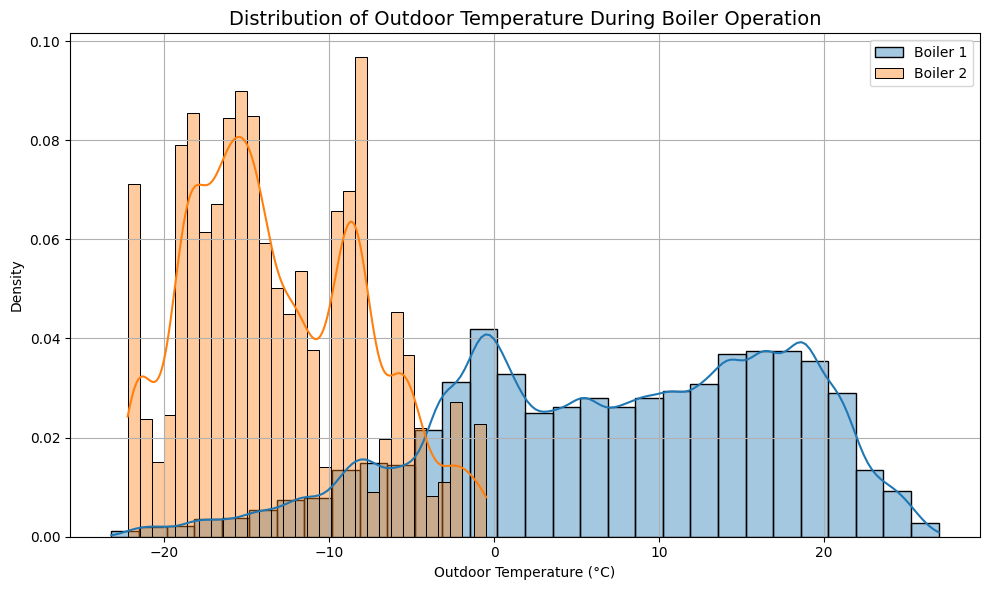

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# 작동 시점만 필터링
boiler1_on = df_main[df_main['보일러 상태 1'] == 1]
boiler2_on = df_main[df_main['보일러 상태 2'] == 1]

plt.figure(figsize=(10, 6))

# KDE + Histogram (둘 다 함께 보기 좋음)
sns.histplot(boiler1_on['외기 건구온도'], color='tab:blue', label='Boiler 1', kde=True, stat='density', alpha=0.4, bins=30)
sns.histplot(boiler2_on['외기 건구온도'], color='tab:orange', label='Boiler 2', kde=True, stat='density', alpha=0.4, bins=30)

plt.title('Distribution of Outdoor Temperature During Boiler Operation', fontsize=14)
plt.xlabel('Outdoor Temperature (°C)')
plt.ylabel('Density')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

## 2차 루프 열부하
- (가정) 그럼 보일러 2번이 왜 있는가? -> 당연히 열 부하가 많으니까 투입시켰겠지?
- 2번 기준으로 열 수요 확인한다.

보일러 2 가동 월: [np.int32(1), np.int32(2), np.int32(3), np.int32(11), np.int32(12)]


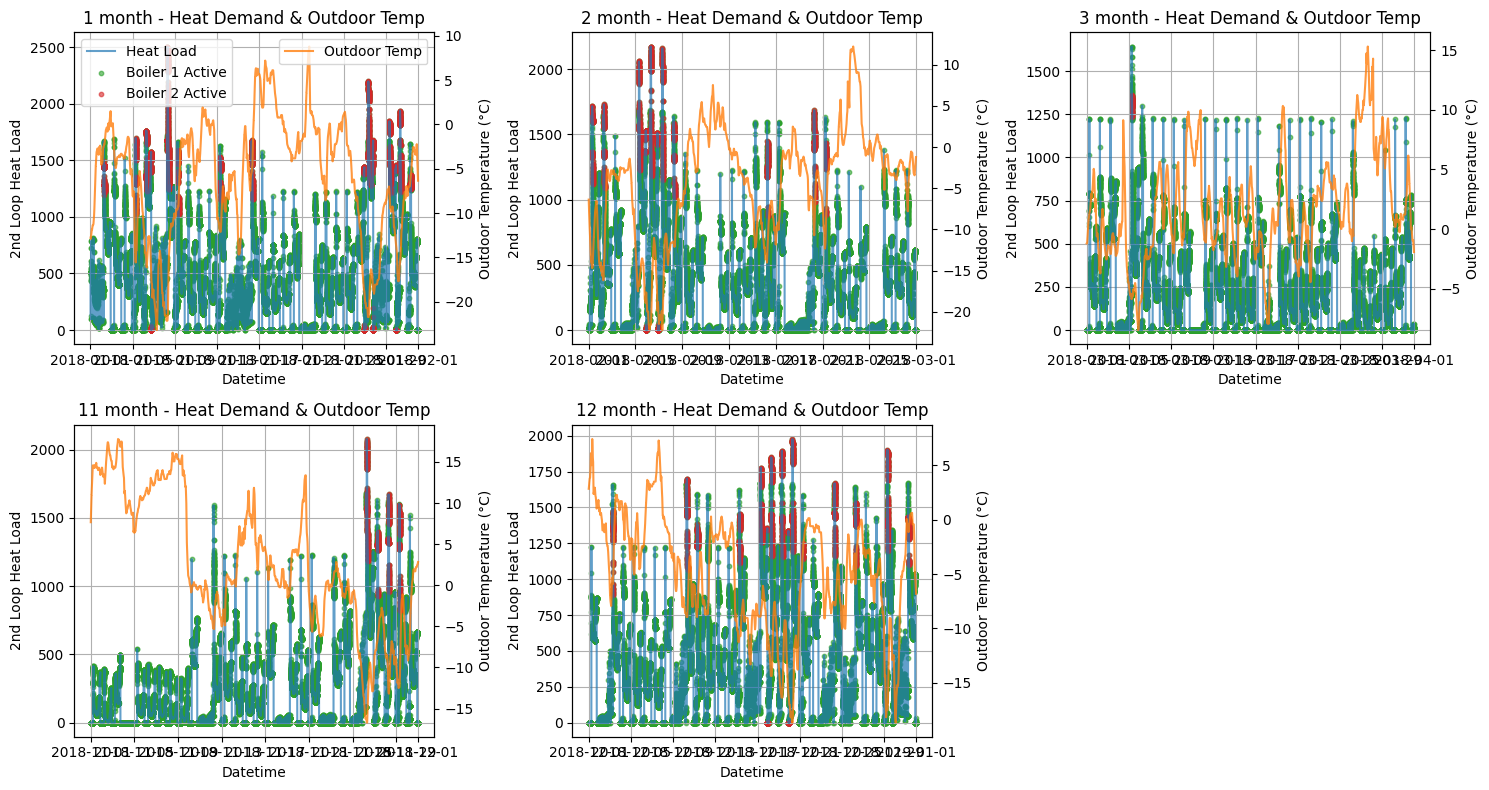

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd

df = df_main.copy()

# datetime 생성
if 'datetime' not in df.columns:
    df['datetime'] = pd.to_datetime(df['ymd'] + ' ' + df['시분'])

# 보일러 2가 켜진 달 추출
active_months = df.loc[df['보일러 상태 2'] == 1, '월'].unique()
active_months = sorted(active_months)
print("보일러 2 가동 월:", active_months)

# subplot 설정
n_cols = 3
n_rows = (len(active_months) + n_cols - 1) // n_cols
fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 4 * n_rows), sharey=False)
axes = axes.flatten()

for i, month in enumerate(active_months):
    sub = df[df['월'] == month]
    ax = axes[i]

    
    ax.plot(sub['datetime'], sub['2차 루프 열부하'], color='tab:blue', alpha=0.7, label='Heat Load')
    ax.scatter(
        sub.loc[sub['보일러 상태 1'] == 1, 'datetime'],
        sub.loc[sub['보일러 상태 1'] == 1, '2차 루프 열부하'],
        color='tab:green', s=10, alpha=0.6, label='Boiler 1 Active'
    )

    
    ax.scatter(
        sub.loc[sub['보일러 상태 2'] == 1, 'datetime'],
        sub.loc[sub['보일러 상태 2'] == 1, '2차 루프 열부하'],
        color='tab:red', s=10, alpha=0.6, label='Boiler 2 Active'
    )

    
    ax2 = ax.twinx()
    ax2.plot(sub['datetime'], sub['외기 건구온도'], color='tab:orange', alpha=0.8, label='Outdoor Temp')

    ax.set_title(f"{month} month - Heat Demand & Outdoor Temp")
    ax.set_xlabel("Datetime")
    ax.set_ylabel("2nd Loop Heat Load")
    ax2.set_ylabel("Outdoor Temperature (°C)")
    ax.grid(True)

    # 첫 번째 subplot에만 범례 추가
    if i == 0:
        ax.legend(loc='upper left')
        ax2.legend(loc='upper right')

# 남는 subplot 제거
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()
